In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from logitboost import LogitBoost
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from data_exploration import explore
from feature_engineering import transformation

In [ ]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

In [34]:
test = pd.read_csv('UNSW_NB15_training-set.csv')
train = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
total_1 = pd.concat([train, test]).drop(['id'],axis=1)

In [4]:
train = train.where(train['service'] == "http").dropna()
test = test.where(test['service'] == "http").dropna()

In [5]:
total = pd.concat([train, test]).drop(['id'],axis=1)

In [6]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def standardize(df):
    return (df-df.mean())/df.std()
    
def min_max(df):
    return (df-df.min())/(df.max() - df.min())

def normalize(df):
    return pd.Dataframe(preprocessing.normalize(df), columns=df.columns)

In [37]:
total_1 = reduce_mem_usage(total_1)

Memory usage of dataframe is 6.40 MB
Memory usage after optimization is: 6.40 MB
Decreased by 0.0%


# Data

In [38]:
normal = train[train['label']==0]
anomaly = train[train['label']==1]

## Checking data types

In [39]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [40]:
train.dtypes

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

* categorical: state, service, proto
* target  = attack_cat, label
* integer but categorial = is_sm_ips_ports, ct_state_ttl, is_ftp_login
* integer = spkts, dpkts, sbytes, dbytes, sttl, dttl, sload, dload, sloss, dloss, swin, dwin, stcpb, dtcpb, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, 
* decimal = dur, rate, sinpkt, dinpkt, sjit, djit, tcprtt, synack, ackdat

# Correlation matrix
Why checking correlation is important ? Check these links:
* [Why Feature Correlation Matters …. A Lot!](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4) and 
* [Feature selection — Correlation and P-value](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf)

In [14]:
def show_correlation(data, method='pearson'):
    correlation_matrix = data.corr(method='pearson') #  ‘pearson’, ‘kendall’, ‘spearman’
    fig = plt.figure(figsize=(12,9))
    sns.heatmap(correlation_matrix,vmax=0.8,square = True) #  annot=True, if fig should show the correlation score too
    plt.show()
    return correlation_matrix

def top_correlations(correlations, limit=0.9):
    columns = correlations.columns
    for i in range(correlations.shape[0]):
        for j in range(i+1, correlations.shape[0]):
            if correlations.iloc[i,j] >= limit:
                print(f"{columns[i]} {columns[j]} {correlations.iloc[i,j]}")
def print_correlations(correlations, col1=None, col2=None):
    columns = correlations.columns
    for i in range(correlations.shape[0]):
        for j in range(i+1, correlations.shape[0]):
            if (col1 == None or col1==columns[i]) and (col2 == None or col2==columns[j]):
                print(f"{columns[i]} {columns[j]} {correlations.iloc[i,j]}")
                return
            elif (col1 == None or col1==columns[j]) and (col2 == None or col2==columns[i]):
                print(f"{columns[i]} {columns[j]} {correlations.iloc[i,j]}")
                return
            
def find_corr(df1, df2):
    return pd.concat([df1, df2], axis=1).corr().iloc[0,1]

def corr(col1, col2='label', df=total):
    return pd.concat([df[col1], df[col2]], axis=1).corr().iloc[0,1]

## Pearson

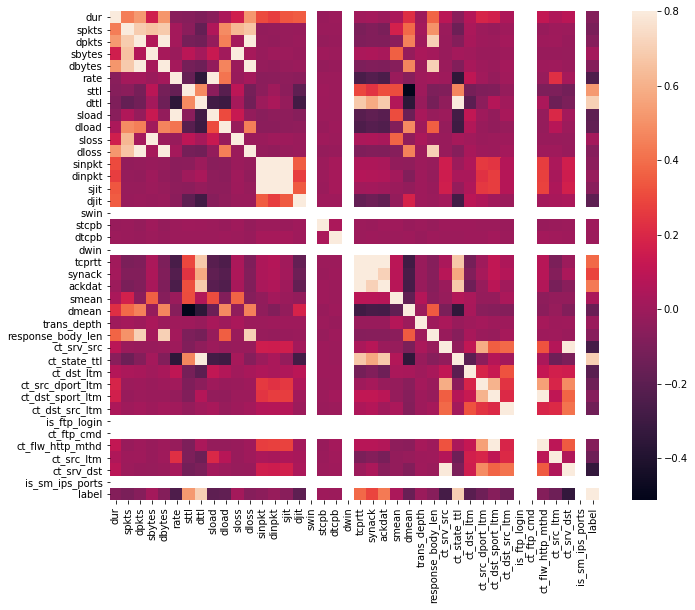

In [41]:
correlation_matrix = show_correlation(total_1)

In [42]:
top_correlations(correlation_matrix, limit=0.9)

dpkts dbytes 0.9984931896670615
dpkts dloss 0.999363792539858
sbytes sloss 0.99569803715516
dbytes dloss 0.9990299973417587
rate sload 0.9235796747401875
dttl ct_state_ttl 0.9901160656713953
sinpkt dinpkt 0.9684006326620596
sinpkt sjit 0.9857096883722878
dinpkt sjit 0.9827448470486293
tcprtt synack 0.9344975265878475
tcprtt ackdat 0.915183821927729


## Spearman

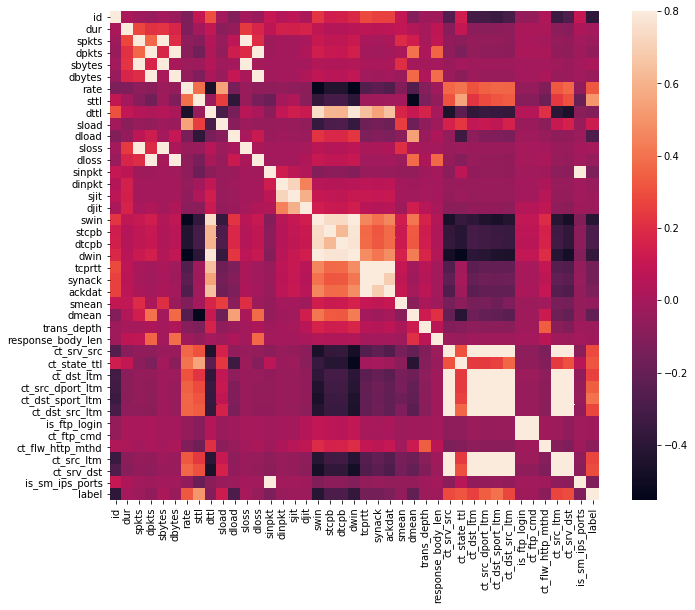

In [43]:
correlation_matrix = show_correlation(train, method='spearman')

In [44]:
top_correlations(correlation_matrix, limit=0.9)

spkts sbytes 0.9657497410285226
spkts sloss 0.9736439932762719
dpkts dbytes 0.9764185516954397
dpkts dloss 0.9815064328007463
sbytes sloss 0.9950271911315601
dbytes dloss 0.9971088501010525
sinpkt is_sm_ips_ports 0.9445057600993081
swin dwin 0.960124697056046
tcprtt synack 0.939473207106296
ct_srv_src ct_dst_src_ltm 0.9337952137620703
ct_srv_src ct_srv_dst 0.9778491535974956
ct_dst_ltm ct_src_dport_ltm 0.9604008284947128
ct_dst_ltm ct_src_ltm 0.9322524473418711
ct_src_dport_ltm ct_dst_sport_ltm 0.9116374681083165
ct_src_dport_ltm ct_src_ltm 0.9331720623310191
ct_dst_src_ltm ct_srv_dst 0.9410468630505523
is_ftp_login ct_ftp_cmd 0.9943410042051406


Most correlated features are :
* spkts, sbytes, sloss 
* dpkts, dbytes, dloss
* sinpkt, is_sm_ips_ports
* swin, dwin
* tcprtt, synack
* ct_srv_src, ct_srv_dst, ct_dst_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm 
* is_ftp_login ct_ftp_cmd

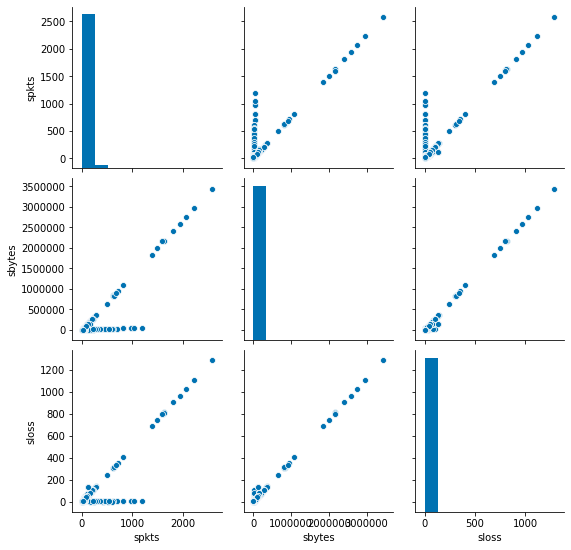

In [45]:
sns.pairplot(total[['spkts', 'sbytes', 'sloss']])

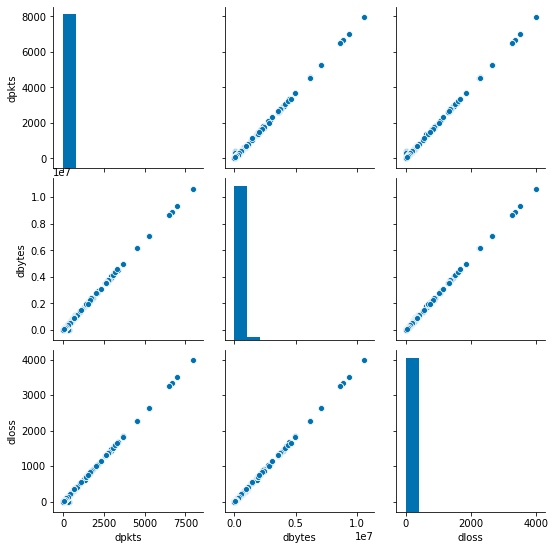

In [46]:
sns.pairplot(total[['dpkts', 'dbytes', 'dloss']])

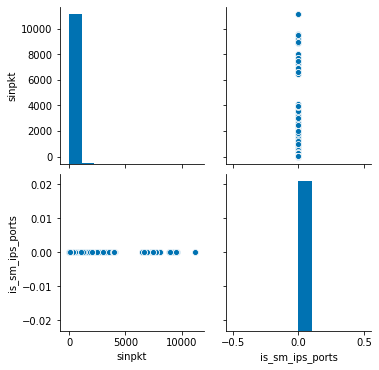

In [47]:
sns.pairplot(total[['sinpkt', 'is_sm_ips_ports']])

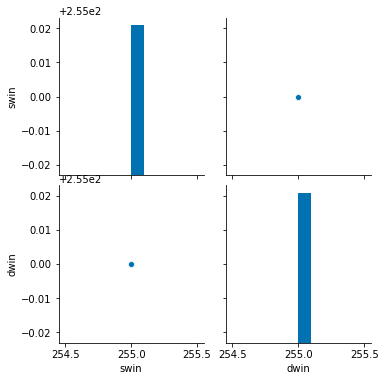

In [48]:
sns.pairplot(total[['swin', 'dwin']])

# plot utils

In [24]:
def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):
    if method != None:
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()
    
def catplot(data, col):
    ax = sns.catplot(x=col, hue="label", col="type",data=data, kind="count", height=5, legend=False, aspect=1.4)
    ax.set_titles("{col_name}")
    ax.add_legend(loc='upper right',labels=['normal','attack'])
    plt.show(ax)

# Categorical
These four columns are categorical: 'attack_cat', 'state', 'service', 'proto'. Among them 'attack_cat' isn't a feature.
These features are categorical but in integer form : 'is_sm_ips_ports', 'ct_state_ttl', 'is_ftp_login'.

In [49]:
def create_count_df(col, data=total):
    df = pd.DataFrame(data[col].value_counts().reset_index().values, columns = [col, 'count'])
    df['percent'] = df['count'].values*100/data.shape[0]
    return df.sort_values(by='percent', ascending=False)

## Label
0 for normal and 1 for attack records

In [50]:
create_count_df('label', train)

,label,count,percent
0,1,45332,55.060001
1,0,37000,44.939999


In [51]:
create_count_df('label', test)

,label,count,percent
0,1,119341,68.062233
1,0,56000,31.937767


So it seems the dataset is pretty balanced, unlike real world data where attack scenarios are rare. Moreover, here attack connections are more than normal connections.

## State
Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)

In [52]:
col = 'state'
create_count_df(col, test)

,state,count,percent
0,INT,82275,46.9229
1,FIN,77825,44.3849
2,CON,13152,7.50081
3,REQ,1991,1.1355
4,RST,83,0.0473363
5,ECO,12,0.00684381
6,no,1,0.000570317
7,PAR,1,0.000570317
8,URN,1,0.000570317


## Service
http, ftp, smtp, ssh, dns, ftp-data ,irc  and (-) if not much used service. More than half of the service data are of - category. 

In [54]:
col = 'service'
create_count_df(col, train)

,service,count,percent
0,-,47153,57.2718
1,dns,21367,25.9522
2,http,8287,10.0653
3,smtp,1851,2.24821
4,ftp,1552,1.88505
5,ftp-data,1396,1.69557
6,pop3,423,0.513774
7,ssh,204,0.247777
8,ssl,30,0.0364378
9,snmp,29,0.0352232


In [57]:
total.loc[~total[col].isin(['-', 'dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']), col] = 'others'

## proto
Transaction protocol. Normal connections of train data have only 5 protocols, where anomaly connections have 129. So we'll convert all other protocols into same value.

In [58]:
col = 'proto'
create_count_df(col, normal)

,proto,count,percent
0,tcp,27848,75.2649
1,udp,8097,21.8838
2,arp,987,2.66757
3,ospf,38,0.102703
4,igmp,30,0.0810811


In [59]:
create_count_df(col, anomaly)[:10]

,proto,count,percent
0,udp,21321,47.033
1,tcp,15247,33.6341
2,unas,3515,7.7539
3,ospf,638,1.40739
4,sctp,324,0.714727
5,any,96,0.211771
6,gre,88,0.194123
7,rsvp,64,0.141181
8,ipv6,61,0.134563
9,sep,58,0.127945


In [60]:
# icmp and rtp columns are in test, but not in train data
total_1.loc[total_1[col].isin(['igmp', 'icmp', 'rtp']), col] = 'igmp_icmp_rtp'
total_1.loc[~total_1[col].isin(['tcp', 'udp', 'arp', 'ospf', 'igmp_icmp_rtp']), col] = 'others'

## is_sm_ips_ports
If source and destination IP addresses equal and port numbers (sport/dport)  equal then, this variable takes value 1 else 0. Seems if it is 1, then the connection is always normal. This feature is highly correlated with sinpkt (0.94131890073567).

## is_ftp_login
If the ftp session is accessed by user and password then 1 else 0. In most of the cases session has no user and password. However there are values 2 and 4 which should not be there.

This feature is totally correlated with ct_ftp_cmd, which counts the number of ftp commands. So dropping this column should be ok.

0.9988554882922012 -0.008761579814961321


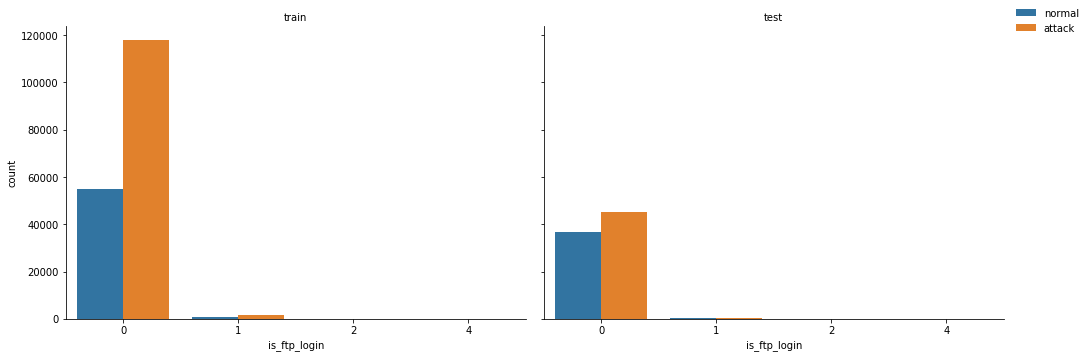

In [42]:
col = 'is_ftp_login'
print(corr('ct_ftp_cmd', col), corr('is_ftp_login', 'label'))
catplot(total, col)
total.drop([col], axis=1, inplace=True)

# Integer Features
## ct_state_ttl
No. for each state according to specific range of values for source/destination time to live (sttl/dttl).

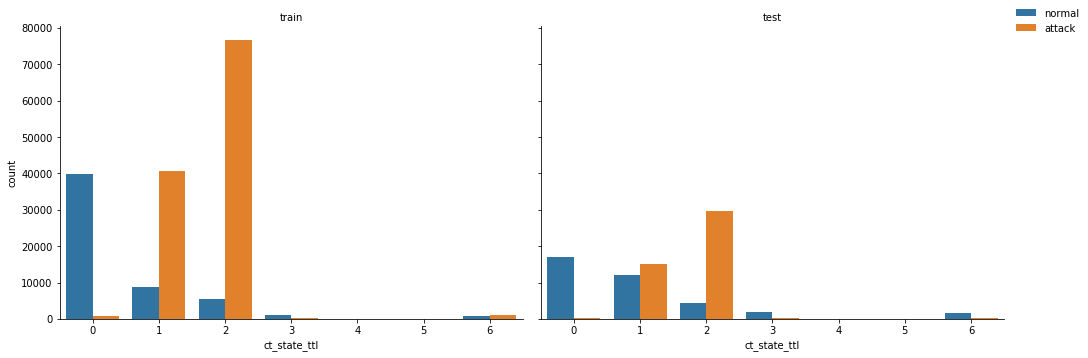

In [43]:
col = 'ct_state_ttl'
catplot(total, col)

## ct_ftp_cmd
No of flows that has a command in ftp session. It has a very low correlation with target. Also is_ftp_login is highly correlated with it (0.9988554882922012).

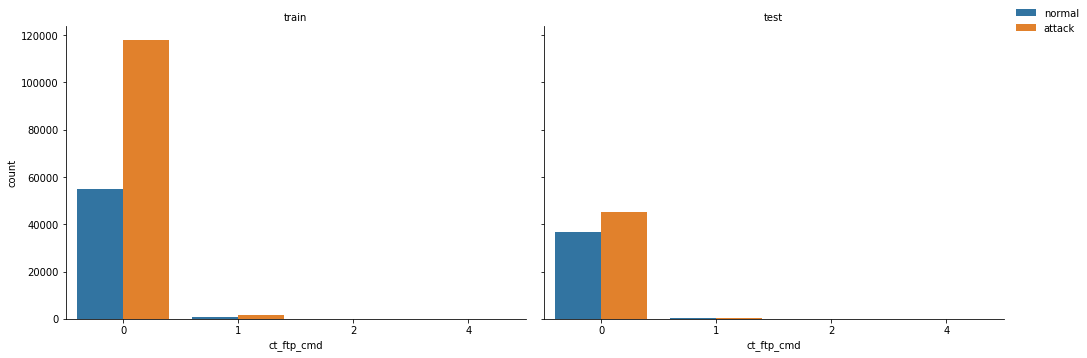

-0.009091577232622904

In [44]:
catplot(total, 'ct_ftp_cmd')
corr('ct_ftp_cmd', 'label')

## ct_flw_http_mthd
No. of flows that has methods such as Get and Post in http service. Seems 0 has more anomaly values, however the correlation is very small with target.

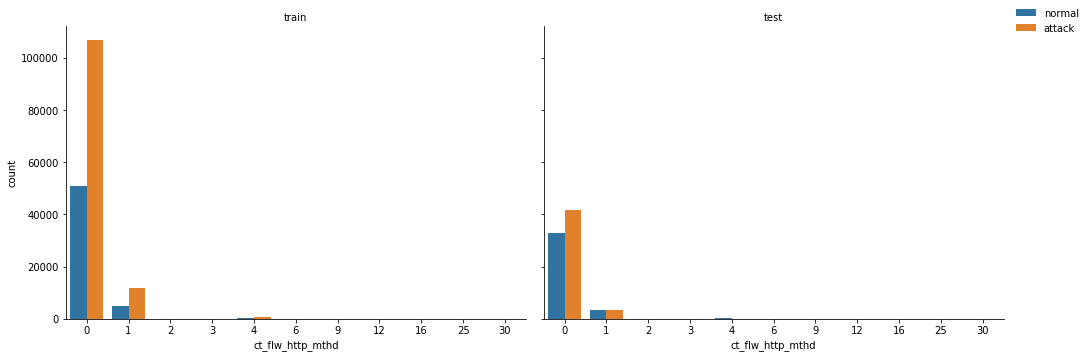

-0.012237160723248125

In [45]:
col = 'ct_flw_http_mthd'
catplot(total, col)
corr(col) # -0.012237160723

In [63]:
create_count_df(col, total_1)

,proto,count,percent
0,tcp,27011,100


## sbytes & dbytes
* sbytes: Source to destination transaction bytes 
* dbytes: Destination to source transaction bytes

These 2 features are higly corelated to number of packets sent (spkts & dpkts). Actually, spkts * smean = sbytes. Also they are closely related to sloss and dloss. So we can drop these 2 here.

In [64]:
print(find_corr(total['spkts']*total['smean'], total['sbytes'])) # 0.999999
print(find_corr(total['dpkts']*total['dmean'], total['dbytes'])) # 0.99999
print(corr('sbytes', 'sloss'), corr('dbytes', 'dloss')) # 0.995771577240429, 0.9967111338305503
total.drop(['sbytes', 'dbytes'], axis=1, inplace=True)

0.9999999103855133
0.9999999750398718
0.99569803715516 0.9990299973417587


## smean & dmean 
Mean of the packet size transmitted. However is it just sbytes/spkts ? The correlation says it is. So we already have this 
info from those other features.

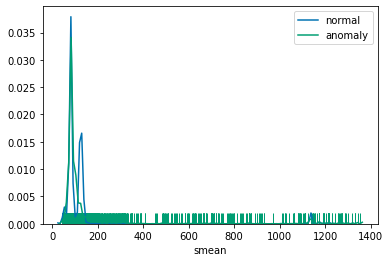

In [65]:
dual_plot('smean')

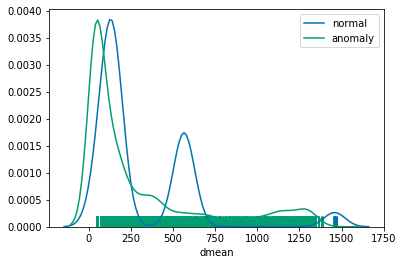

In [66]:
dual_plot('dmean')

In [50]:
total['smean_log1p'] = total['smean'].apply(np.log1p)
total['dmean_log1p'] = total['dmean'].apply(np.log1p)

# -0.02837244879012871 -0.2951728296856902 -0.05807468815031313 -0.5111549621216057
print(corr('smean'), corr('dmean'), corr('smean_log1p'), corr('dmean_log1p'))
# So we have better correlation with label after applying log1p. 
total.drop(['smean', 'dmean'], axis=1, inplace=True)

-0.02837244879017641 -0.2951728296847456 -0.05807473669862242 -0.5111549603490384


## spkts and dpkts
* spkts : Source to destination packet count 
* dpkts: Destination to source packet count

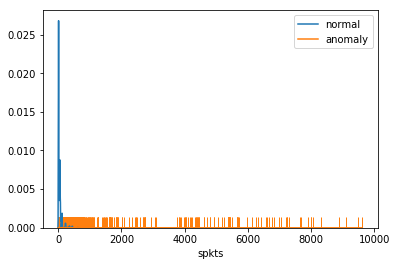

In [51]:
col = 'spkts'
dual_plot(col)

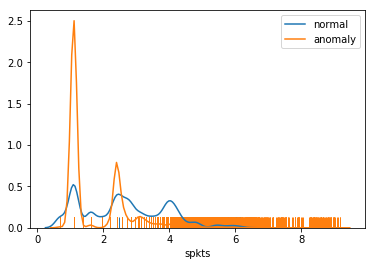

In [52]:
dual_plot(col, method=np.log1p)

In [53]:
total['spkts_log1p'] = total['spkts'].apply(np.log1p)
total['dpkts_log1p'] = total['dpkts'].apply(np.log1p)

# -0.043040466783819634 -0.09739388286233619 -0.3468819761209388 -0.45005074723539357
print(corr('spkts'), corr('dpkts'), corr('spkts_log1p'), corr('dpkts_log1p'))
# So we have better correlation with label after applying log1p. 
total.drop(['spkts', 'dpkts'], axis=1, inplace=True)

-0.043040466783783184 -0.09739388286214869 -0.3468819761215252 -0.450050747235394


## sttl & dttl
* sttl: Source to destination time to live value 
* dttl: Destination to source time to live value

For sttl most of the anomalies have live values around 65 and 250. Its correlation with the target value is high too.
However, for dttl both types have nearly same distribution. So the correlation with target is very low.

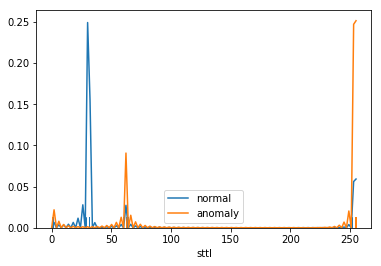

In [54]:
col = 'sttl'
dual_plot(col) # 0.62408238, after applying log1p 0.61556952425

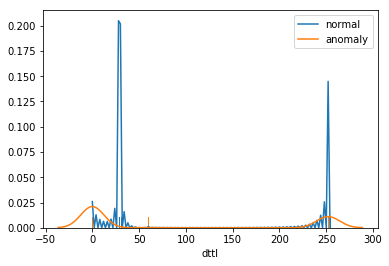

In [55]:
col = 'dttl'
dual_plot(col) # corr -0.09859087338578788

## sloss & dloss
* sloss: Source packets retransmitted or dropped 
* dloss: Destination packets retransmitted or dropped

Sloss is highly correlated with spkts and sbytes (more than .91). Similarly dloss is highly correlated with dpkts and dbytes. 
However, though packets sent is related loss of packets, this isn't quite linearly related like packet number and size. So we keep both for now.

Values are mostly between 0 to 3. Yet some values are more than several thousands.

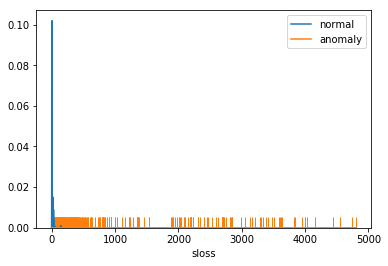

In [56]:
dual_plot('sloss')

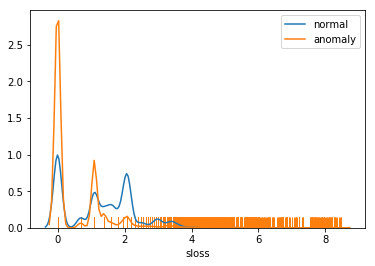

In [57]:
# So log1p makes it easier to differentiate
dual_plot('sloss', method=np.log1p)

In [58]:
total['sloss_log1p'] = total['sloss'].apply(np.log1p)
total['dloss_log1p'] = total['dloss'].apply(np.log1p)
# 0.001828274080103508 -0.07596097807462938 -0.3454351103223904 -0.3701913238787703
print(corr('sloss'), corr('dloss'), corr('sloss_log1p'), corr('dloss_log1p') )
total.drop(['sloss', 'dloss'], axis=1, inplace= True)

0.001828274080093212 -0.0759609780746232 -0.345435110320645 -0.3701913238778073


## swin & dwin
TCP window advertisement value. Except 0 and 255 other values(1-254) occur mostly once only. So we can separate them into 3 groups. And we also see after binning their correlation with target remains same.

In [59]:
total['swin'].value_counts().loc[lambda x: x>1]

0      134632
255    123021
Name: swin, dtype: int64

In [60]:
total['dwin'].value_counts().loc[lambda x: x>1]

0      137157
255    120498
27          2
Name: dwin, dtype: int64

In [61]:
print(corr('swin'), corr('dwin'))

-0.36487721423192127 -0.3391656759085246


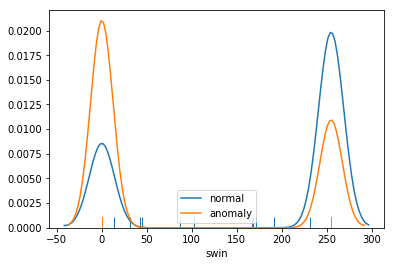

In [62]:
dual_plot('swin')

In [63]:
selected = ['swin', 'dwin']
kbins = preprocessing.KBinsDiscretizer(n_bins=[3, 3], encode='ordinal', strategy='uniform')
total[selected] = pd.DataFrame(kbins.fit_transform(total[selected]), columns=selected)
print(corr('swin'), corr('dwin'))

-0.3648685344294963 -0.33914336235333503


## stcpb & dtcpb
TCP base sequence number. It has a really big range, 0 to 5e9. However, anomaly connections are mostly around 0. 

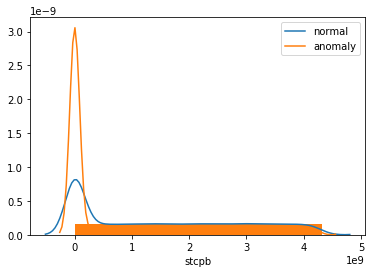

In [64]:
col = 'stcpb'
dual_plot(col)

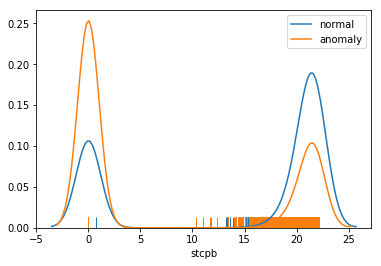

In [65]:
dual_plot(col, method=np.log1p)

In [66]:
total['stcpb_log1p'] = total['stcpb'].apply(np.log1p)
total['dtcpb_log1p'] = total['dtcpb'].apply(np.log1p)
# -0.2665849100492664 -0.2635428109654134 -0.33898970769021913 -0.33835676091281974
print(corr('stcpb'), corr('dtcpb'), corr('stcpb_log1p'), corr('dtcpb_log1p'))
total.drop(['stcpb', 'dtcpb'], axis=1, inplace= True)

-0.26658491004988316 -0.26354281096530374 -0.3389897076888727 -0.3383567609129128


### tcprtt & synack & ackdat
* tcprtt is the TCP connection setup round-trip time, the sum of ’synack’ and ’ackdat’.
* synack: TCP connection setup time, the time between the SYN and the SYN_ACK packets.
* ackdat : TCP connection setup time, the time between the SYN_ACK and the ACK packets.

As tcprtt, is just the sum of other two features, it doesn't add any extra info to our models. So we can just drop it for now.
Applying preprocessing on synack and ackdat didn't improve much. From graph we can see, anomaly connections generally have values around 0.

In [67]:
total.drop(['tcprtt'], axis=1, inplace=True)

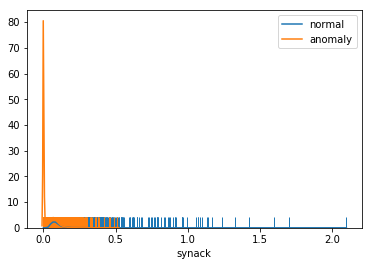

In [68]:
dual_plot('synack')

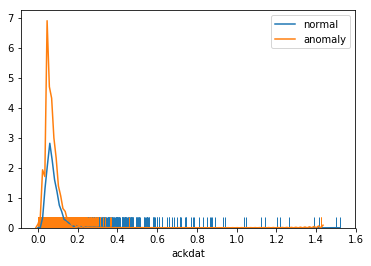

In [69]:
dual_plot('ackdat')

## trans_depth
Represents the pipelined depth into the connection of http request/response transaction. After depth 5 to 172 occurences are few.

In [70]:
col = 'trans_depth'
print(corr(col)) # -0.0022256544
create_count_df(col, total)

0.002245977533494535


,trans_depth,count,percent
0,0,232251,90.134007
1,1,25295,9.816706
2,2,108,0.041914
3,4,4,0.001552
4,3,4,0.001552
5,39,2,0.000776
6,5,2,0.000776
7,80,1,0.000388
8,172,1,0.000388
9,163,1,0.000388


## response_body_len
Actual uncompressed content size of the data transferred from the server’s http service. 
The values range between 0 to 5.24M.

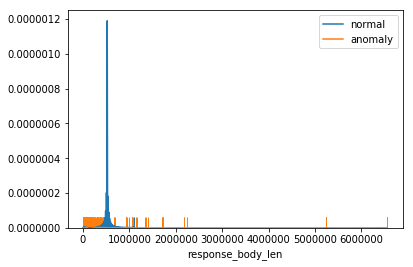

In [71]:
col = 'response_body_len'
dual_plot(col)

In [72]:
total["response_body_len_log1p"] = total["response_body_len"].apply(np.log1p)

# slight improve
# -0.018930127454048158 -0.03261972203078345
print(corr('response_body_len'), corr('response_body_len_log1p'))
total.drop(['response_body_len'], axis=1, inplace=True)

-0.018930127454016125 -0.07651272487741327


## ct_srv_src
No. of connections that contain the same service and source address in 100 connections according to the last time. Most of the normal connections are within 10. It is highly correlated to ct_srv_dst.

In [73]:
col = 'ct_srv_src'
print(total[col].value_counts())

1     49876
2     29616
3     24482
4     19895
5     16280
6     14562
7     11708
8      8092
9      6848
10     6341
33     4604
12     4331
11     4325
16     3549
14     3478
17     3011
13     2877
34     2788
18     2328
26     2328
29     2290
32     2108
28     2107
15     2028
27     1961
30     1946
31     1920
23     1896
24     1814
25     1721
22     1662
21     1629
19     1623
20     1344
37     1237
35     1136
36     1116
43     1012
39      895
38      795
40      695
45      523
42      488
44      485
41      416
46      320
51      279
47      227
50      156
49      154
52      111
48       89
63       63
59       30
54       27
53       26
58       25
Name: ct_srv_src, dtype: int64


0.24659616767805462


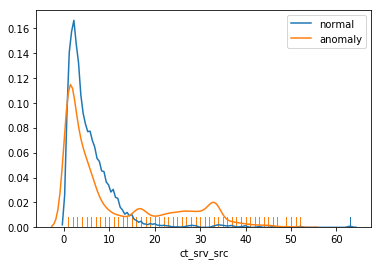

In [74]:
print(corr(col)) # 0.24659616767
dual_plot(col)

## ct_srv_dst
No. of connections that contain the same service and destination address in 100 connections according to the last time. It is highly correlated to ct_srv_src too. It has a slight better correlation with label than ct_srv_src. So the other one can be dropped to check for possible improvement.

1     58824
2     28745
3     24142
4     18809
5     15992
6     13406
7     10672
8      7311
9      6034
10     5878
33     4568
12     4138
11     4025
16     3580
14     3384
17     2977
34     2785
13     2508
18     2455
26     2310
29     2206
32     2124
28     2053
30     2002
27     1990
31     1949
25     1828
24     1770
23     1760
22     1549
15     1524
21     1479
20     1359
19     1304
37     1237
35     1206
36     1081
43      957
39      940
38      775
40      655
42      518
45      493
44      464
41      416
51      330
46      320
47      214
50      156
48      137
49      105
62       62
52       59
59       30
54       27
53       26
58       25
Name: ct_srv_dst, dtype: int64


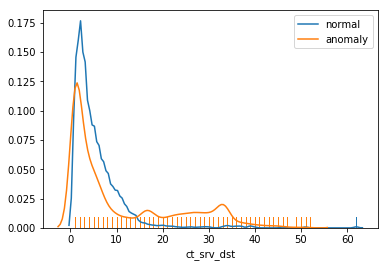

In [75]:
col = 'ct_srv_dst'
print(total[col].value_counts())
# graph is same as ct_srv_src
dual_plot(col)

In [76]:
# 0.2478122357. they are very correlated 0.97946681, need to check whether dropping one benefits
print(corr('ct_srv_dst'), corr('ct_srv_src', 'ct_srv_dst'))

0.2478122357172172 0.9794668130717727


## ct_src_ltm & ct_dst_ltm
No. of connections of the same source/destination address in 100 connections according to the last recorder time.
Values are well between 0 to 51 and very few values after 48. They are much correlated , but not to the point of dropping one.

In [77]:
col = 'ct_src_ltm'
print(corr(col))
create_count_df(col, total)

0.25249817658200413


,ct_src_ltm,count,percent
0,1,63870,24.787230
1,2,48965,19.002767
2,3,29180,11.324431
3,4,18863,7.320519
4,5,12297,4.772328
5,6,8573,3.327085
6,17,7613,2.954520
7,16,6817,2.645601
8,7,6263,2.430600
9,8,5804,2.252467


In [78]:
print(corr('ct_dst_ltm'))
create_count_df('ct_dst_ltm', total)

0.240776441215579


,ct_dst_ltm,count,percent
0,1,83627,32.454700
1,2,48640,18.876638
2,3,27434,10.646828
3,4,17313,6.718981
4,5,9441,3.663946
5,6,7473,2.900187
6,16,7112,2.760087
7,17,6796,2.637451
8,7,5927,2.300202
9,18,5663,2.197747


In [79]:
corr('ct_src_ltm', 'ct_dst_ltm')

0.9015817705707642

## ct_src_dport_ltm & ct_dst_sport_ltm
* ct_src_dport_ltm : No of connections of the same source address and the destination port in 100 connections according to the last time.
* ct_dst_sport_ltm: No of connections of the same destination address and the source port in 100 connections according to the last time.

In [80]:
for col in ['ct_src_dport_ltm', 'ct_dst_sport_ltm']:
    print(corr(col))
    print(create_count_df(col, total))

0.3185184197865368
    ct_src_dport_ltm   count    percent
0                  1  135974  52.769984
1                  2   36610  14.207930
2                  3   14495   5.625347
3                 16    8927   3.464469
4                  4    8651   3.357356
5                 17    6631   2.573417
6                  6    4306   1.671110
7                 18    4176   1.620659
8                  7    3448   1.338130
9                  5    2979   1.156116
10                33    2711   1.052109
11                14    2329   0.903859
12                 8    2196   0.852243
13                25    2085   0.809165
14                10    2042   0.792477
15                12    1812   0.703217
16                13    1802   0.699336
17                11    1697   0.658587
18                 9    1641   0.636854
19                15    1615   0.626763
20                34    1410   0.547205
21                43     952   0.369461
22                32     841   0.326383
23                20 

In [81]:
corr('ct_src_dport_ltm', 'ct_dst_sport_ltm')

0.9083371617431901

# Decimal Features
## dur 
recorded total duration. Normal connections are mostly within 5. However, this feature has a poor correlation with label.


0.029096117024572817


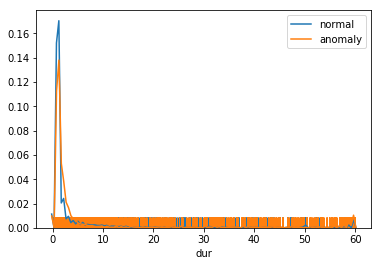

In [82]:
col = 'dur'
print(corr(col)) # 0.0290961170, correlation gets worse after log1p
dual_plot(col)

## rate
This feature isn't mentioned is feature list. It has value upto 1M. Anomaly connections are mostly around 0.

0.335882638820406


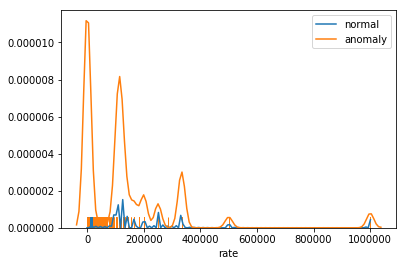

In [83]:
col = 'rate'
print(corr(col))
dual_plot(col) # cor 0.3358, after applying log1p it becomes 0.31581108

## sinpkt & dinpkt
* sinpkt: Source interpacket arrival time (mSec)
* dinpkt: Destination interpacket arrival time (mSec)

sinpkt is highly correlated with is_sm_ips_ports (0.9421206). Will dropping one of them benefit ?

In [84]:
col = 'sinpkt'
corr(col, 'is_sm_ips_ports')

0.9421206233368904

-0.15545369808669798


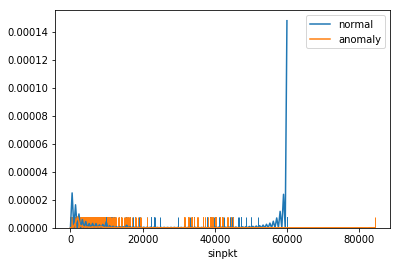

In [85]:
print(corr(col)) # corr -0.1554536980863
dual_plot(col) 

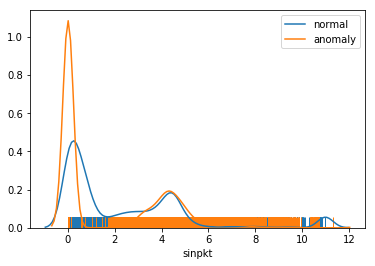

In [86]:
dual_plot(col, method=np.log1p)

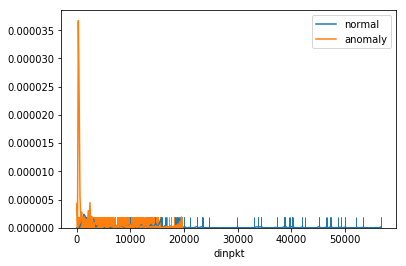

In [87]:
dual_plot('dinpkt')

In [88]:
total['sinpkt_log1p'] = total['sinpkt'].apply(np.log1p)
total['dinpkt_log1p'] = total['dinpkt'].apply(np.log1p)

# slight improve in correlation
# -0.1554536980867726 -0.030136042428744566 -0.16119699304378052 -0.07408113676641241
print(corr('sinpkt'), corr('dinpkt'), corr('sinpkt_log1p'), corr('dinpkt_log1p'))
total.drop(['sinpkt', 'dinpkt'], axis=1, inplace= True)

-0.15545369808669798 -0.030136042428568287 -0.16119699304366145 -0.07408113676637938


## sload & dload
* sload: Source bits per second
* dload: Destination bits per second

The values are really big and in bits.

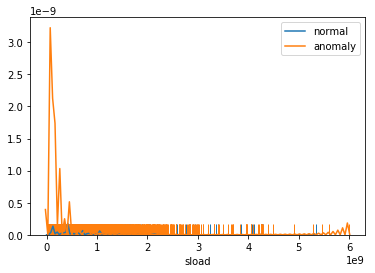

In [89]:
dual_plot('sload')

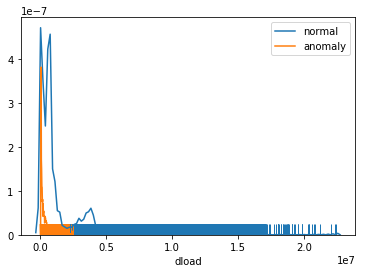

In [90]:
dual_plot('dload')

In [91]:
total['sload_log1p'] = total['sload'].apply(np.log1p)
total['dload_log1p'] = total['dload'].apply(np.log1p)
# 0.16524867685764016 -0.35216880416636837 0.3397788822586144 -0.5919440288535992
print(corr('sload'), corr('dload'), corr('sload_log1p'), corr('dload_log1p'))
total.drop(['sload', 'dload'], axis=1, inplace=True)

0.16524867685755187 -0.3521688041654803 0.3397788822582179 -0.5919440288530265


## sjit & djit
Source and Destination jitter in mSec. Preprocessing didn't improve anything.

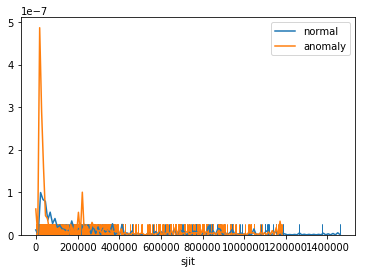

In [92]:
dual_plot('sjit')

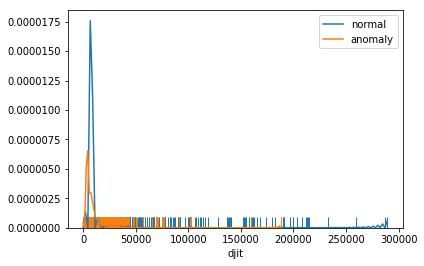

In [93]:
dual_plot('djit')